In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from plotting_helper import * 
figures_path = 'figures/'
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']  

from brian2 import *
from brian2tools import *

In [2]:
LIF_eqs = '''
    dv/dt = (vrest-v)/tau  - g_syn_i * (v-E_inh)/tau - g_syn_e * (v-E_exc)/tau : volt (unless refractory)
    dg_syn_i/dt = -g_syn_i/tau : 1
    dg_syn_e/dt = -g_syn_e/tau : 1
    tau : second
    E_L: volt
    E_inh : volt
    E_exc : volt
    vrest :volt
'''

LIF_reset = '''
    v = vrest
'''

syn_eq = '''
    ds/dt = - s/tau_s : 1 (clock-driven)
    dvp/dt = (-vp + v)/tau_p : volt (clock-driven)
    dvm/dt = (-vm + v)/tau_m : volt (clock-driven)
    dglutamate/dt = - glutamate/tau_glutamate : 1 (clock-driven)

    sig_LTP = 1/(1+exp(k_LTP*(-(v - theta_NMDA)+0*mV))) : 1 (constant over dt)
    dv_NMDA_rise/dt = (-v_NMDA_rise + clip(clip(sig_LTP - v_NMDA,0,100) - v_NMDA_rise,0,100))/tau_NMDA_rise : 1 (clock-driven)             
    dv_NMDA/dt = (NMDA_amp * v_NMDA_rise - v_NMDA)/tau_NMDA_fall : 1 (clock-driven)
    sig_LTD = 1/(1+exp(k_LTD*(-(v - theta_VDCC)+0*mV))) : 1 (constant over dt)
    dVDCC_rise/dt = (-VDCC_rise + clip(clip(sig_LTD - VDCC,0,100) -VDCC_rise, 0, 100))/tau_VDCC_rise : 1 (clock-driven) 
    dVDCC/dt = (VDCC_amp * VDCC_rise - VDCC) * 1/tau_VDCC_fall : 1 (clock-driven)
    Ca = VDCC**(exp(-c_ca)*20) + v_NMDA**(exp(-c_ca)*20) * int(s>0) : 1 (constant over dt)
    w_vdp = eta_vdp * Ca  * (v_NMDA * LTP_amp - VDCC * LTD_amp) * glutamate : 1 (constant over dt)
    w_cl = eta_cl * A_p_cl  * (v - theta_p_cl)/mV * int((v - theta_p_cl)/mV > 0 ) * (vp - theta_m_cl)/mV*int((vp - theta_m_cl)/mV > 0 ) * s : 1 (constant over dt)
    w_mb = eta_mb * (A_p_mb  * (vp - theta_p_mb)/mV*int((vp - theta_p_mb)/mV > 0 ) - A_d_mb *(vm - theta_m_mb)/mV * int((vm - theta_m_mb)/mV > 0)) * s : 1 (constant over dt)



    theta_p_cl : volt
    theta_m_cl : volt
    theta_p_mb : volt
    theta_m_mb : volt
    A_p_cl : 1
    A_d_cl : 1
    A_p_mb : 1
    A_d_mb : 1
    eta_cl : 1
    eta_mb : 1
    eta_vdp : 1
    
    tau_p : second
    tau_m : second
    
    tau_s : second
    tau_glutamate : second 
    g :1
    
    theta_NMDA : volt
    tau_NMDA_rise : second
    tau_NMDA_fall : second
    NMDA_amp : 1
    theta_VDCC : volt
    tau_VDCC_rise : second
    tau_VDCC_fall : second
    VDCC_amp : 1
    k_LTP : 1/volt
    k_LTD : 1/volt
    LTP_amp : 1
    LTD_amp : 1
    Apre : 1  
    wmin : 1
    wmax : 1
    c_ca : 1
    tau_w : second
'''

onpre = '''
    s += g
    glutamate += Apre
    g_syn_e += 0.5 * g_EE
    w_cl = eta_cl * A_d_cl *(vm - theta_m_cl)/mV * int((vm - theta_m_cl)/mV > 0)
    '''

g_EE = 1/log(100)
g_I = 4/log(20)

def unpack_params(Syn, vdp_params, cl_params, mb_params, taus, wmin, wmax):
    
        
    Syn.theta_p_cl = cl_params[0] * mV
    Syn.theta_m_cl = cl_params[1] * mV
    Syn.theta_p_mb = mb_params[0] * mV
    Syn.theta_m_mb = mb_params[1] * mV
    Syn.A_p_cl = cl_params[2] 
    Syn.A_d_cl = cl_params[3]
    Syn.A_p_mb = mb_params[2]
    Syn.A_d_mb = mb_params[3]
    Syn.eta_cl = cl_params[4]
    Syn.eta_mb = mb_params[4]



    
    Syn.Apre = vdp_params[0] 
    Syn.tau_glutamate = vdp_params[1] *ms
    
    Syn.k_LTD = vdp_params[2] /mV 
    LTD_rise = vdp_params[3]
    LTD_fall = vdp_params[4]
    LTP_rise = vdp_params[8]
    LTP_fall = vdp_params[9]
    Syn.tau_VDCC_rise = LTD_rise * ms
    Syn.tau_VDCC_fall = LTD_fall * ms
    Syn.theta_VDCC  = vdp_params[5] * mV
    Syn.LTD_amp = vdp_params[6]
    
    Syn.k_LTP = vdp_params[7] / mV
    Syn.tau_NMDA_rise = LTP_rise * ms
    Syn.tau_NMDA_fall =  LTP_fall * ms
    Syn.theta_NMDA = vdp_params[10] * mV
    Syn.LTP_amp = vdp_params[11]
    Syn.eta_vdp = vdp_params[13]
    Syn.wmin = wmin
    Syn.wmax = wmax
    Syn.c_ca = vdp_params[12]
    
    Syn.tau_w = 1*ms
    Syn.tau_s = taus[0] * ms
    Syn.tau_p = taus[1] * ms
    Syn.tau_m = taus[2] * ms
    Syn.g = taus[3] 
    Syn.vp = taus[4] * mV
    Syn.vm = taus[4] * mV

    
    #predetermined by time constants
    Syn.NMDA_amp = (LTP_rise/LTP_fall)**(LTP_fall/(LTP_rise - LTP_fall))
    Syn.VDCC_amp = (LTD_rise/LTD_fall)**(LTD_fall/(LTD_rise - LTD_fall))

    return Syn


def mechanism_ICA(inhib_onset, pres_time, vdp_p, cl_p, mb_p, tau_p, samples = 100, rseed = 42): 
    
    start_scope()
    seed(rseed)
    
    n_f = 3  #number of factors
    n_per_f = 10 #number of neurons per factor
    
    
    Inp = NeuronGroup(n_f*n_per_f*samples,'rates : Hz', threshold='rand()<pattern_inp(t,i)*dt', refractory = 3 * ms)
    E = NeuronGroup(n_f*samples,LIF_eqs, threshold='v > -49 * mV', 
                refractory=1*ms, method='euler', reset=LIF_reset)
    E.vrest = vrest * mV
    E.v = 'vrest  + abs(20 *mV* rand())'
    E.tau = 10 * ms 
    E.E_L = vrest * mV 
    E.E_inh = -80 * mV
    E.E_exc = 0 * mV
    Inh = NeuronGroup(n_f*n_per_f*samples, 'rates:Hz',threshold='rand()<pattern_i(t,i)*dt', refractory = 3 * ms)
    
    
    #our rates are timed arrays so we can change the inhib onset
    on_rate = 100
    i_rate = 50 #just to test for now, that means that each neuron is firing 2 spikes on average
    
    #our run time is n_f * pattern time
    on_pattern = np.zeros([n_f,n_f*n_per_f*samples])
    inhib_pattern = np.zeros([n_f*pres_time, n_f*n_per_f*samples])
    on_pattern[0,:2*n_per_f*samples] = on_rate
    inhib_pattern[inhib_onset:pres_time, 2*n_per_f*samples:] = i_rate
    on_pattern[1,n_per_f*samples:] = on_rate
    inhib_pattern[pres_time+inhib_onset:pres_time*2, :n_per_f*samples] = i_rate
    on_pattern[2,:n_per_f*samples] = on_rate
    on_pattern[2, 2*n_per_f*samples:] = on_rate
    inhib_pattern[2*pres_time+inhib_onset:pres_time*n_f, n_per_f*samples:2*n_per_f*samples] = i_rate
    
    pattern_inp = TimedArray(on_pattern * Hz, dt = pres_time*ms) 
    pattern_i = TimedArray(inhib_pattern * Hz, dt = 1*ms)
        
    inp1 = Synapses(Inp, E, syn_eq, on_pre = onpre, method = 'euler')
    inp2 = Synapses(Inp, E, syn_eq, on_pre = onpre, method = 'euler')
    inp3 = Synapses(Inp, E, syn_eq, on_pre = onpre, method = 'euler')
    patterni = np.zeros([n_f*n_per_f], dtype = 'int')
    patternj = np.zeros([n_f*n_per_f], dtype = 'int')
    patterni[:n_per_f] = np.arange(0,n_per_f, dtype = 'int')
    patterni[n_per_f:2*n_per_f] = np.arange(0,n_per_f, dtype = 'int')+(samples*n_per_f)
    patterni[2*n_per_f:] = np.arange(0,n_per_f, dtype = 'int')+(samples*n_per_f*2)
    for n in range(samples): 
        inp1.connect(i = patterni+(n*n_per_f), j = n) 
        inp2.connect(i = patterni+(n*n_per_f), j = n+samples)
        inp3.connect(i = patterni+(n*n_per_f), j = n+samples*2)
    inp1 = unpack_params(inp1, vdp_p, cl_p, mb_p, tau_p, 0,2)
    inp1.w_vdp = .5 #with random init? 
    inp1.w_mb = .5
    inp1.w_cl = .5
    
    
    inp2 = unpack_params(inp2, vdp_p, cl_p, mb_p, tau_p, 0,2)
    inp2.w_vdp = .5 #with random init? 
    inp2.w_mb = .5
    inp2.w_cl = .5
    
    
    inp3 = unpack_params(inp3, vdp_p, cl_p, mb_p, tau_p, 0,2)
    inp3.w_vdp = .5 #with random init? 
    inp3.w_mb = .5
    inp3.w_cl = .5
    inhE = Synapses(Inh, E, 'w:1', on_pre = 'g_syn_i += w*g_I', method = 'euler')
    #structured inhibition 
    for n in range(samples): 
        inhE.connect(i = np.arange(n_per_f)+(n*n_per_f), j = n) 
        inhE.connect(i = np.arange(n_per_f)+(n*n_per_f)+(samples*n_per_f), j = n+samples) 
        inhE.connect(i = np.arange(n_per_f)+(n*n_per_f)+(samples*n_per_f*2), j = n+2*samples)
    inhE.w = 0.5

    
    
    monwf1 = StateMonitor(inp1, ['w_vdp', 'w_cl', 'w_mb'], dt = 1*ms, record = inp1[:samples*n_per_f,:])
    monwf2 = StateMonitor(inp2, ['w_vdp', 'w_cl', 'w_mb'], dt = 1*ms, record = inp2[samples*n_per_f:samples*2*n_per_f,:])
    monwf3 = StateMonitor(inp3, ['w_vdp', 'w_cl', 'w_mb'], dt = 1*ms, record = inp3[samples*2*n_per_f:,:])
    
    nf2_ind = np.arange(samples*2*n_per_f, dtype = int)
    nf2_ind[samples*n_per_f:] = nf2_ind[samples*n_per_f:]+samples*n_per_f
    monwnf1 = StateMonitor(inp1, ['w_vdp', 'w_cl', 'w_mb'], dt = 1*ms, record = inp1[samples*n_per_f:,:])
    monwnf2 = StateMonitor(inp2, ['w_vdp', 'w_cl', 'w_mb'], dt = 1*ms, record = inp2[nf2_ind,:])
    monwnf3 = StateMonitor(inp3, ['w_vdp', 'w_cl', 'w_mb'], dt = 1*ms, record = inp3[:samples*2*n_per_f,:])
    
    monv = StateMonitor(E, ['v'], dt = 1*ms, record = True)
    monr1 = PopulationRateMonitor(E[:samples])
    monr2 = PopulationRateMonitor(E[samples:2*samples])
    monr3 = PopulationRateMonitor(E[2*samples:])
    
    run(pres_time * n_f * ms, report = 'text')
    
    return [monwf1,monwf2,monwf3],[monwnf1,monwnf2,monwnf3], monv, [monr1, monr2, monr3]
    
    
    


In [3]:
i_onset = 5
pres_time = 50
vrest = -79
taus = [15,10,7,1/15, vrest]
mb_param = [-69, -58,1.e-2, 8.e-4,1]
cl_param = [-75, -65,8.e-5, 8e-4,10]
vdp_param = [0.1, 10, 0.4, 1, 20, -43.75, 0.17, 0.4, 1, 5, -40.75, 1.0, 3.0,100]
sample_size = 100

result_w,result_nfw, result_v, result_r  = mechanism_ICA(i_onset, pres_time, vdp_param, cl_param, mb_param, taus, samples = sample_size)

WARNING    'vrest' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value -79. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s


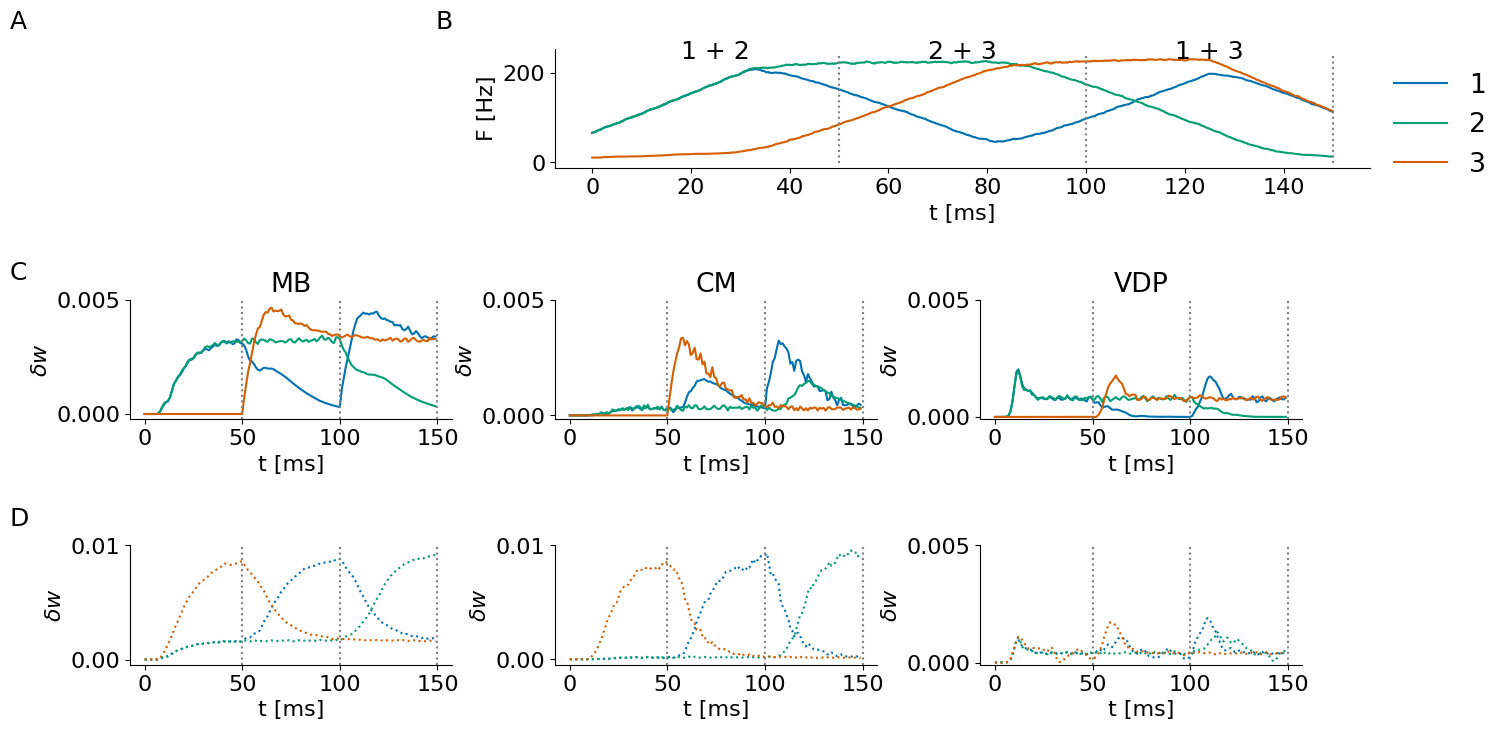

In [7]:
 #Do the figure

layout = '''
    AABBBB
    AABBBB
    CCCCCC
    CCCCCC
    DDDDDD
    '''

fig = plt.figure(figsize=(16, 8))

height_ratios = [1,0.1,1,0.05,1]
width_ratios = [1,0.1,1,0.1,1,0.1]

specs, gs = panel_specs(layout, fig=fig)
gs.set_height_ratios(height_ratios)
gs.set_width_ratios(width_ratios)
gs.hspace=0.8
axes = {}
for letter in 'ABCD':
    axes[letter] = ax = fig.add_subplot(specs[letter])
label_panels(axes, letters='ABCD', postfix='', offset_left=1.2)
for a in list('ABCD'):
    axes[a].set_axis_off()

    
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']  

#first one for the circuit diagram
ax = fig.add_subplot(gs[0,2:6])
#ax.plot(result_v.t/ms,np.mean(result_v.v[0:1*sample_size,:]/mV,axis = 0), label = '1', color = palette[0])
#ax.plot(result_v.t/ms,np.mean(result_v.v[1*sample_size:2*sample_size,:]/mV,axis = 0), label = '2', color = palette[1])
#ax.plot(result_v.t/ms,np.mean(result_v.v[2*sample_size:,:]/mV,axis = 0), label = '3', color = palette[2])

ax.plot(result_r[0].t/ms,result_r[0].smooth_rate(window='flat', width = 50 *ms)/Hz, label = '1', color = palette[0])
ax.plot(result_r[1].t/ms,result_r[1].smooth_rate(window='flat', width = 50*ms)/Hz, label = '2', color = palette[1])
ax.plot(result_r[2].t/ms,result_r[2].smooth_rate(window='flat', width = 50*ms)/Hz, label = '3', color = palette[2])

miny, maxy = ax.get_ylim()
ax.plot([50,50], [miny, maxy], color = 'grey', linestyle = ':')
ax.text(25, maxy+5, '1 + 2' , ha = 'center', va = 'center', fontsize = 18)
ax.plot([100,100], [miny, maxy], color = 'grey', linestyle = ':')
ax.text(75, maxy+5, '2 + 3' , ha = 'center', va = 'center', fontsize = 18)
ax.plot([150,150], [miny, maxy], color = 'grey', linestyle = ':')
ax.text(125, maxy+5, '1 + 3' , ha = 'center', va = 'center', fontsize = 18)
ax.set_xlabel('t [ms]')
#ax.set_ylabel('$\mu(v)$ [mV]')
ax.set_ylabel('F [Hz]')
ax.legend( bbox_to_anchor=(1.0, 1.0), loc='upper left',  frameon = False)
clear_axes(ax)


ax = fig.add_subplot(gs[2,4])
ax.plot(result_w[0].t/ms, np.mean(result_w[0].w_vdp, axis = 0), color = palette[0])
ax.plot(result_w[1].t/ms, np.mean(result_w[1].w_vdp, axis = 0), color = palette[1])
ax.plot(result_w[2].t/ms, np.mean(result_w[2].w_vdp, axis = 0), color = palette[2])
miny, maxy = ax.get_ylim()
ax.set_ylim(miny,0.005)
miny, maxy = ax.get_ylim()
ax.plot([50,50], [miny, maxy], color = 'grey', linestyle = ':')
ax.plot([100,100], [miny, maxy], color = 'grey', linestyle = ':')
ax.plot([150,150], [miny, maxy], color = 'grey', linestyle = ':')
ax.set_xlabel('t [ms]')
ax.set_ylabel('$\delta w$')
clear_axes(ax)
ax.set_title('VDP')

ax = fig.add_subplot(gs[2,2])
ax.plot(result_w[0].t/ms, np.mean(result_w[0].w_cl, axis = 0), color = palette[0])
ax.plot(result_w[1].t/ms, np.mean(result_w[1].w_cl, axis = 0), color = palette[1])
ax.plot(result_w[2].t/ms, np.mean(result_w[2].w_cl, axis = 0), color = palette[2])
miny, maxy = ax.get_ylim()
ax.set_ylim(miny,0.005)
miny, maxy = ax.get_ylim()
ax.plot([50,50], [miny, maxy], color = 'grey', linestyle = ':')
ax.plot([100,100], [miny, maxy], color = 'grey', linestyle = ':')
ax.plot([150,150], [miny, maxy], color = 'grey', linestyle = ':')
ax.set_xlabel('t [ms]')
ax.set_ylabel('$\delta w$')
clear_axes(ax)
ax.set_title('CM')

ax = fig.add_subplot(gs[2,0])
ax.plot(result_w[0].t/ms, np.mean(result_w[0].w_mb, axis = 0), color = palette[0])
ax.plot(result_w[1].t/ms, np.mean(result_w[1].w_mb, axis = 0), color = palette[1])
ax.plot(result_w[2].t/ms, np.mean(result_w[2].w_mb, axis = 0), color = palette[2])
miny, maxy = ax.get_ylim()
ax.set_ylim(miny,0.005)
miny, maxy = ax.get_ylim()
ax.plot([50,50], [miny, maxy], color = 'grey', linestyle = ':')
ax.plot([100,100], [miny, maxy], color = 'grey', linestyle = ':')
ax.plot([150,150], [miny, maxy], color = 'grey', linestyle = ':')
ax.set_xlabel('t [ms]')
ax.set_ylabel('$\delta w$')
clear_axes(ax)
ax.set_title('MB')

ax = fig.add_subplot(gs[4,4])
ax.plot(result_w[0].t/ms, np.mean(result_nfw[0].w_vdp, axis = 0), color = palette[0], linestyle = ':')
ax.plot(result_w[1].t/ms, np.mean(result_nfw[1].w_vdp, axis = 0), color = palette[1], linestyle = ':')
ax.plot(result_w[2].t/ms, np.mean(result_nfw[2].w_vdp, axis = 0), color = palette[2], linestyle = ':')
miny, maxy = ax.get_ylim()
ax.set_ylim(miny,0.005)
miny, maxy = ax.get_ylim()
ax.plot([50,50], [miny, maxy], color = 'grey', linestyle = ':')
ax.plot([100,100], [miny, maxy], color = 'grey', linestyle = ':')
ax.plot([150,150], [miny, maxy], color = 'grey', linestyle = ':')
ax.set_xlabel('t [ms]')
ax.set_ylabel('$\delta w$')
clear_axes(ax)

ax = fig.add_subplot(gs[4,2])
ax.plot(result_w[0].t/ms, np.mean(result_nfw[0].w_cl, axis = 0), color = palette[0], linestyle = ':')
ax.plot(result_w[1].t/ms, np.mean(result_nfw[1].w_cl, axis = 0), color = palette[1], linestyle = ':')
ax.plot(result_w[2].t/ms, np.mean(result_nfw[2].w_cl, axis = 0), color = palette[2], linestyle = ':')
miny, maxy = ax.get_ylim()
ax.set_ylim(miny,0.01)
miny, maxy = ax.get_ylim()
ax.plot([50,50], [miny, maxy], color = 'grey', linestyle = ':')
ax.plot([100,100], [miny, maxy], color = 'grey', linestyle = ':')
ax.plot([150,150], [miny, maxy], color = 'grey', linestyle = ':')
ax.set_xlabel('t [ms]')
ax.set_ylabel('$\delta w$')
clear_axes(ax)


ax = fig.add_subplot(gs[4,0])
ax.plot(result_w[0].t/ms, np.mean(result_nfw[0].w_mb, axis = 0), color = palette[0], linestyle = ':')
ax.plot(result_w[1].t/ms, np.mean(result_nfw[1].w_mb, axis = 0), color = palette[1], linestyle = ':')
ax.plot(result_w[2].t/ms, np.mean(result_nfw[2].w_mb, axis = 0), color = palette[2], linestyle = ':')
miny, maxy = ax.get_ylim()
ax.set_ylim(miny,0.01)
miny, maxy = ax.get_ylim()
ax.plot([50,50], [miny, maxy], color = 'grey', linestyle = ':')
ax.plot([100,100], [miny, maxy], color = 'grey', linestyle = ':')
ax.plot([150,150], [miny, maxy], color = 'grey', linestyle = ':')
ax.set_xlabel('t [ms]')
ax.set_ylabel('$\delta w$')
clear_axes(ax)


plt.savefig(figures_path+'fig4_factor_mechanism_r_traces.pdf', bbox_inches='tight')
plt.show()

In [22]:
###do parameter sweeps and calculate 4 metrics to compare the different runs

def parameter_asweeps(vdp_as, cl_as, mb_as):
    
    mb_param = [-69, -58,mb_as[0], mb_as[1],1]
    cl_param = [-75, -65,cl_as[0], cl_as[1],10]
    vdp_param = [0.1, 10, 0.4, 1, 20, -43.75, vdp_as[0], 0.4, 1, 5, -40.75, vdp_as[1], 3.0,100]
    
    taus = [15,10,7,1/15, vrest]
    
    dat, _ = mechanism_ICA(5, 50, vdp_param, cl_param, mb_param, taus, samples = 100, rseed = 42)
    #calculate the slopes
    sl_vdp = np.zeros([4])
    sl_cl = np.zeros([4])
    sl_mb = np.zeros([4])
    for ind, t in enumerate(np.arange(50,100,25, dtype = int)): 
        sl_vdp[ind] = (dat[0].w_vdp[t+25]- dat[0].w_vdp[t])/25
        sl_vdp[ind+2] = (dat[1].w_vdp[t+25]- dat[1].w_vdp[t])/25
        
        sl_cl[ind] = (dat[0].w_cl[t+25]- dat[0].w_cl[t])/25
        sl_cl[ind+2] = (dat[1].w_cl[t+25]- dat[1].w_cl[t])/25
        
        sl_mb[ind] = (dat[0].w_mb[t+25]- dat[0].w_mb[t])/25
        sl_mb[ind+2] = (dat[1].w_mb[t+25]- dat[1].w_mb[t])/25
    return sl_vdp, sl_cl, sl_mb

def parameter_tausweeps(tau):
    
    mb_param = [-69, -58,1.e-2, 8.e-4,1]
    cl_param = [-75, -65,8.e-5, 8e-4,10]
    vdp_param = [1/tau[0], tau[0], 0.4, 1, 20, -43.75, 0.17, 0.4, 1, 5, -40.75, 1.0, 3.0,100]
    
    taus = [tau[0],tau[1],tau[2],1/tau[0], vrest]
    
    dat, _, _,_ = mechanism_ICA(5, 50, vdp_param, cl_param, mb_param, taus, samples = 100, rseed = 42)
    #calculate the slopes
    sl_vdp = np.zeros([4])
    sl_cl = np.zeros([4])
    sl_mb = np.zeros([4])
    
    dat1_vdp = np.mean(dat[0].w_vdp, axis = 0)
    dat1_cl = np.mean(dat[0].w_cl,axis = 0)
    dat1_mb = np.mean(dat[0].w_mb, axis = 0)
    dat2_mb = np.mean(dat[1].w_mb,axis = 0)
    dat2_vdp = np.mean(dat[1].w_vdp, axis = 0)
    dat2_cl = np.mean(dat[1].w_cl,axis = 0)
    
    for ind, t in enumerate(np.array([50,75], dtype = int)): 
        sl_vdp[ind] = (dat1_vdp[t+24]- dat1_vdp[t])/24
        sl_vdp[ind+2] = (dat2_vdp[t+74]- dat2_vdp[t+50])/24
        
        sl_cl[ind] = (dat1_cl[t+24]- dat1_cl[t])/24
        sl_cl[ind+2] = (dat2_cl[t+74]- dat2_cl[t+50])/24
        
        sl_mb[ind] = (dat1_mb[t+24]- dat1_mb[t])/24
        sl_mb[ind+2] = (dat2_mb[t+74]- dat2_mb[t+50])/24
    return sl_vdp, sl_cl, sl_mb
    

In [23]:
######do the temporal filtering sweep

#pre
tau_pre = np.arange(1,20,1, dtype = int)

res_pre = np.zeros([tau_pre.shape[0],3,4])
for ind, tau_p in enumerate(tau_pre): 
    res_pre[ind] = parameter_tausweeps([tau_p, 10,7])
    
###the tau minus and tau_plus
tau_minus = np.arange(1,20,1, dtype = int)
tau_plus = np.arange(1,20,1, dtype = int)
res_mp = np.zeros([tau_minus.shape[0], tau_plus.shape[0], 3,4])
for indm, tau_m in enumerate(tau_minus): 
    for indp, tau_p in enumerate(tau_plus): 
        res_mp[indm, indp] = parameter_tausweeps([10, tau_m,tau_p])
        

WARNING    'vrest' is an internal variable of group 'neurongroup_6', but also exists in the run namespace with the value -79. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duratio

WARNING    'tau_m' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses', but also exists in the run namespace with the value 1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duratio

WARNING    'tau_m' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses', but also exists in the run namespace with the value 2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duratio

WARNING    'tau_m' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses', but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duratio

WARNING    'tau_m' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 4. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 4. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses', but also exists in the run namespace with the value 4. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duratio

WARNING    'tau_m' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 5. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 5. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses', but also exists in the run namespace with the value 5. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duratio

WARNING    'tau_m' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 6. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 6. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses', but also exists in the run namespace with the value 6. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duratio

WARNING    'tau_m' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 7. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 7. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses', but also exists in the run namespace with the value 7. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duratio

WARNING    'tau_m' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 8. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 8. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses', but also exists in the run namespace with the value 8. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duratio

WARNING    'tau_m' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 9. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 9. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses', but also exists in the run namespace with the value 9. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duratio

WARNING    'tau_m' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 10. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 10. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses', but also exists in the run namespace with the value 10. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duratio

WARNING    'tau_m' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 11. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 11. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses', but also exists in the run namespace with the value 11. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duratio

WARNING    'tau_m' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 12. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 12. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses', but also exists in the run namespace with the value 12. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duratio

WARNING    'tau_m' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 13. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 13. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses', but also exists in the run namespace with the value 13. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duratio

WARNING    'tau_m' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 14. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 14. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses', but also exists in the run namespace with the value 14. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duratio

WARNING    'tau_m' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 15. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 15. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses', but also exists in the run namespace with the value 15. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duratio

WARNING    'tau_m' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 16. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 16. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses', but also exists in the run namespace with the value 16. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duratio

WARNING    'tau_m' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 17. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 17. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses', but also exists in the run namespace with the value 17. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duratio

WARNING    'tau_m' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 18. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 18. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses', but also exists in the run namespace with the value 18. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duratio

WARNING    'tau_m' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 19. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value 19. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'tau_m' is an internal variable of group 'synapses', but also exists in the run namespace with the value 19. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in 1s
Starting simulation at t=0. s for a duratio

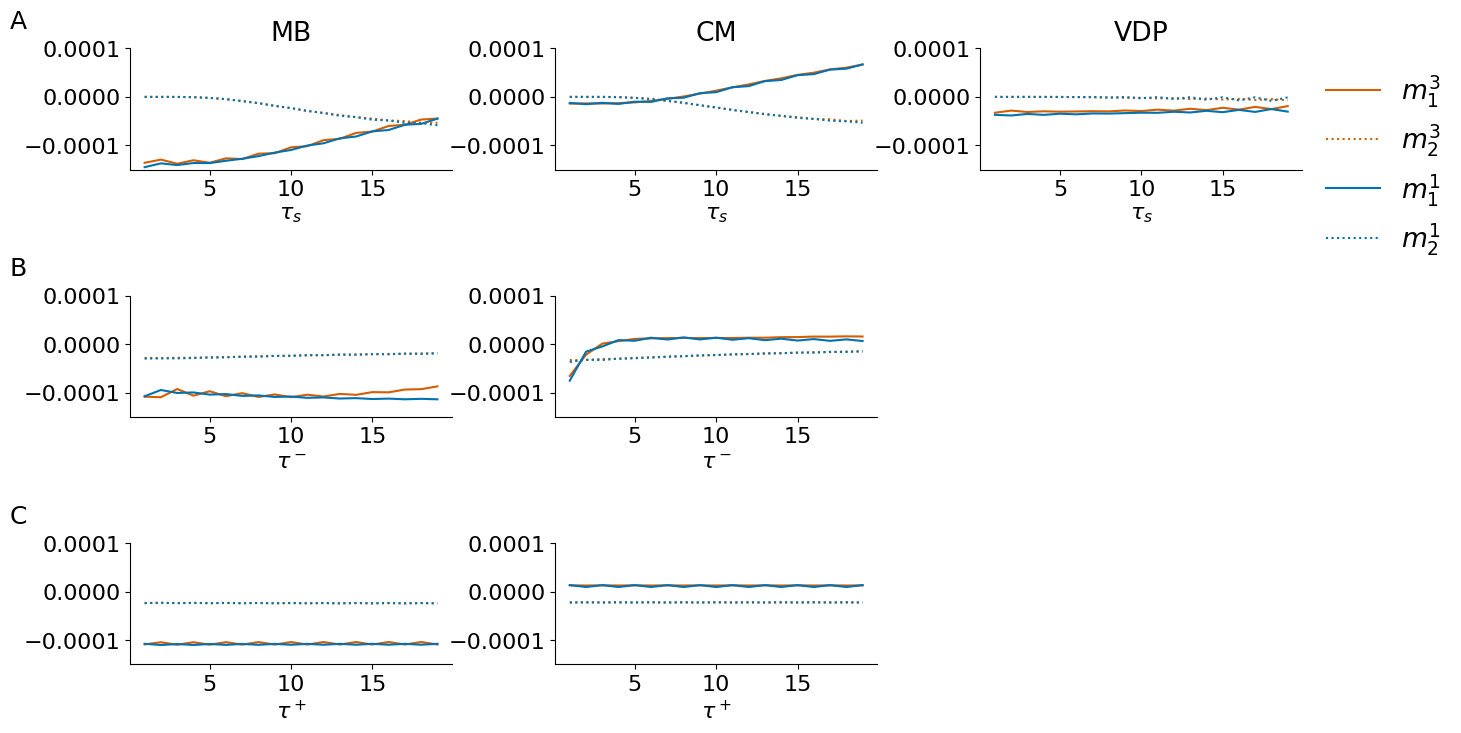

In [32]:
#plot the results

layout = '''
    AAAAAA
    AAAAAA
    BBBBBB
    BBBBBB
    CCCCCC
    '''

fig = plt.figure(figsize=(16, 8))

height_ratios = [1,0.05,1,0.05,1]
width_ratios = [1,0.1,1,0.1,1,0.1]

specs, gs = panel_specs(layout, fig=fig)
gs.set_height_ratios(height_ratios)
gs.set_width_ratios(width_ratios)
gs.hspace=0.8
axes = {}
for letter in 'ABC':
    axes[letter] = ax = fig.add_subplot(specs[letter])
label_panels(axes, letters='ABC', postfix='', offset_left=1.2)
for a in list('ABC'):
    axes[a].set_axis_off()

    
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']  

ax = fig.add_subplot(gs[0,0])
ax.plot(tau_pre, res_pre[:,2,0], color = palette[2])
ax.plot(tau_pre, res_pre[:,2,2], color = palette[0])
ax.plot(tau_pre, res_pre[:,2,1], color = palette[2], linestyle = ':')
ax.plot(tau_pre, res_pre[:,2,3], color = palette[0], linestyle = ':')
ax.set_ylim(-15e-5, 10e-5)
ax.set_title('MB')
ax.set_xlabel('$\\tau_s$')
clear_axes(ax)

ax = fig.add_subplot(gs[0,2])
ax.plot(tau_pre, res_pre[:,1,0], color = palette[2])
ax.plot(tau_pre, res_pre[:,1,1], color = palette[2], linestyle = ':')
ax.plot(tau_pre, res_pre[:,1,2], color = palette[0])
ax.plot(tau_pre, res_pre[:,1,3], color = palette[0], linestyle = ':')
ax.set_ylim(-15e-5, 10e-5)
ax.set_title('CM')
ax.set_xlabel('$\\tau_s$')
clear_axes(ax)

ax = fig.add_subplot(gs[0,4])
ax.plot(tau_pre, res_pre[:,0,0], color = palette[2], label = '$m^3_1$')
ax.plot(tau_pre, res_pre[:,0,1], color = palette[2], linestyle = ':', label = '$m^3_2$')
ax.plot(tau_pre, res_pre[:,0,2], color = palette[0], label = '$m^1_1$')
ax.plot(tau_pre, res_pre[:,0,3], color = palette[0], linestyle = ':', label = '$m^1_2$')
ax.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left',  frameon = False)
ax.set_ylim(-15e-5, 10e-5)
ax.set_title('VDP')
ax.set_xlabel('$\\tau_s$')
clear_axes(ax)

ax = fig.add_subplot(gs[2,0])
ax.plot(tau_minus, res_mp[:,6,2,0], color = palette[2])
ax.plot(tau_minus, res_mp[:,6,2,1], color = palette[2], linestyle = ':')
ax.plot(tau_minus, res_mp[:,6,2,2], color = palette[0])
ax.plot(tau_minus, res_mp[:,6,2,3], color = palette[0], linestyle = ':')
ax.set_ylim(-15e-5, 10e-5)
ax.set_xlabel('$\\tau^-$')
clear_axes(ax)

ax = fig.add_subplot(gs[2,2])
ax.plot(tau_minus, res_mp[:,6,1,0], color = palette[2])
ax.plot(tau_minus, res_mp[:,6,1,1], color = palette[2], linestyle = ':')
ax.plot(tau_minus, res_mp[:,6,1,2], color = palette[0])
ax.plot(tau_minus, res_mp[:,6,1,3], color = palette[0], linestyle = ':')
ax.set_ylim(-15e-5, 10e-5)
ax.set_xlabel('$\\tau^-$')
clear_axes(ax)

ax = fig.add_subplot(gs[4,0])
ax.plot(tau_plus, res_mp[9,:,2,0], color = palette[2])
ax.plot(tau_plus, res_mp[9,:,2,1], color = palette[2], linestyle = ':')
ax.plot(tau_plus, res_mp[9,:,2,2], color = palette[0])
ax.plot(tau_plus, res_mp[9,:,2,3], color = palette[0], linestyle = ':')
ax.set_ylim(-15e-5, 10e-5)
ax.set_xlabel('$\\tau^+$')
clear_axes(ax)

ax = fig.add_subplot(gs[4,2])
ax.plot(tau_plus, res_mp[9,:,1,0], color = palette[2])
ax.plot(tau_plus, res_mp[9,:,1,1], color = palette[2], linestyle = ':')
ax.plot(tau_plus, res_mp[9,:,1,2], color = palette[0])
ax.plot(tau_plus, res_mp[9,:,1,3], color = palette[0], linestyle = ':')
ax.set_ylim(-15e-5, 10e-5)
ax.set_xlabel('$\\tau^+$')
clear_axes(ax)

plt.savefig(figures_path+'appfig_tau_influence_m.pdf', bbox_inches='tight')
plt.show()